In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
import astropy.cosmology.units as cu
import os
import sys
sys.path.insert(0, work)
from illustris_sim import TNGSim
import corrfunc_ls
import tools

#### load in data sets

In [4]:
z = 1.
# initialize simulation and snapshot
sim = TNGSim('TNG300-3', redshift=z)

In [5]:
# luminous red galaxies / emission line galaxies -> tracers
# (input number densities from Table 1 in Sullivan et al. 2023)
LRG_idx = sim.gal_idx('LRG', 'DESI', n=2e-4, prints=True) # 
ELG_idx = sim.gal_idx('ELG', 'DESI', n=5e-4, prints=True) # 

input number density: 2.00e-04 (h/Mpc)^3
target number of subhalos: 1723
input number density: 5.00e-04 (h/Mpc)^3
target number of subhalos: 4307


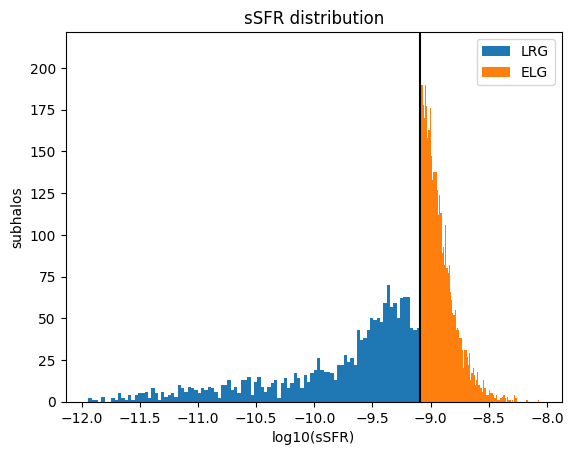

In [6]:
# check sSFR cutoffS
fig, ax = plt.subplots()
_, _, _ = ax.hist(np.log10(sim.sSFR()[LRG_idx].value), bins=100, label='LRG')
_, _, _ = ax.hist(np.log10(sim.sSFR()[ELG_idx].value), bins=100, label='ELG')
ax.axvline(-9.09, color='k')
ax.set_xlabel('log10(sSFR)')
ax.set_ylabel('subhalos')
ax.set_title('sSFR distribution')
ax.legend()

In [7]:
# look at mass ratios: galaxy (stellar) mass / host halo mass
LRG_mass = sim.stellar_mass()[LRG_idx]
ELG_mass = sim.stellar_mass()[ELG_idx]
LRG_halo_mass = sim.subhalo_mass()[LRG_idx]
ELG_halo_mass = sim.subhalo_mass()[ELG_idx]

In [8]:
mass_ratio_LRG = LRG_mass / LRG_halo_mass
mass_ratio_ELG = ELG_mass / ELG_halo_mass

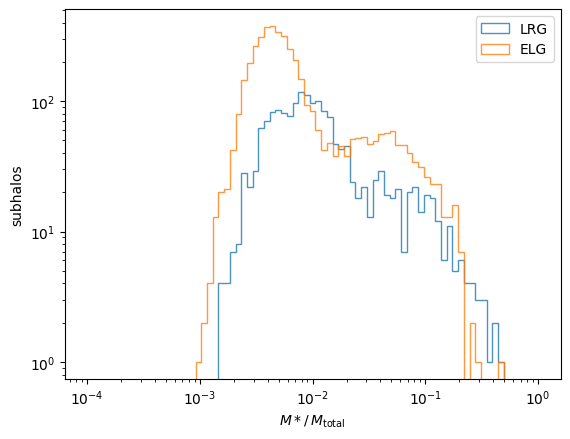

In [9]:
fig, ax = plt.subplots()
bins = np.logspace(-4, 0, 80)
kwargs = dict(bins=bins, histtype='step', alpha=0.8)
_, _, _ = ax.hist(mass_ratio_LRG.value, label='LRG', **kwargs)
_, _, _ = ax.hist(mass_ratio_ELG.value, label='ELG', **kwargs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M* /\, M_\mathrm{total}$')
ax.set_ylabel('subhalos')
ax.legend()

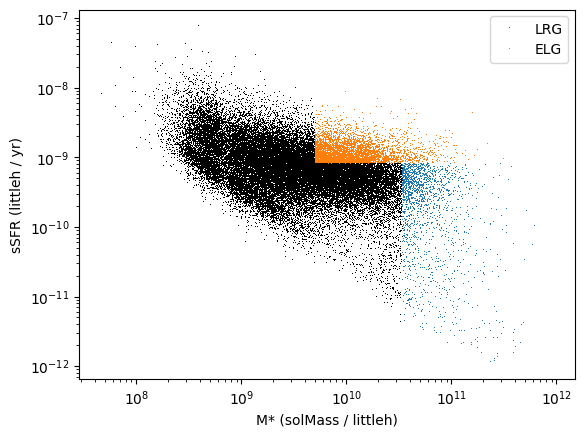

In [10]:
fig, ax = plt.subplots()
ax.plot(sim.stellar_mass().value, sim.sSFR().value, marker=',', ls='None', color='k')
ax.plot(sim.stellar_mass()[LRG_idx].value, sim.sSFR()[LRG_idx].value, marker=',', ls='None', label='LRG')
ax.plot(sim.stellar_mass()[ELG_idx].value, sim.sSFR()[ELG_idx].value, marker=',', ls='None', label='ELG')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'M* ({sim.stellar_mass().unit})')
ax.set_ylabel(f'sSFR ({sim.sSFR().unit})')
ax.legend()

#### correlation function parameters

In [11]:
# parameters
randmult = 3
rmin = 1.
rmax = 75.
nbins = 20
nthreads = 12

### gal x gal

In [12]:
LRG_pos = sim.subhalo_pos()[LRG_idx]
ELG_pos = sim.subhalo_pos()[ELG_idx]

In [13]:
ravg, LRG_galxgal = corrfunc_ls.compute_3D_ls_auto(LRG_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)

Text(0.5, 1.0, '2-pt. Gal x Gal (LRG, TNG300-3, z=1.00)')

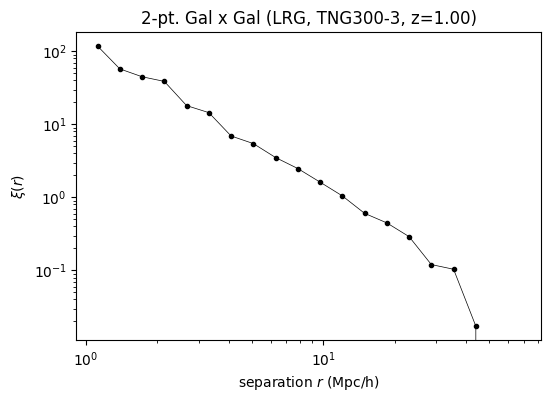

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ravg, LRG_galxgal, 'k.-', lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Gal x Gal (LRG, {sim.sim_tag})')

In [15]:
ravg, ELG_galxgal = corrfunc_ls.compute_3D_ls_auto(ELG_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)

Text(0.5, 1.0, '2-pt. Gal x Gal (ELG, TNG300-3, z=1.00)')

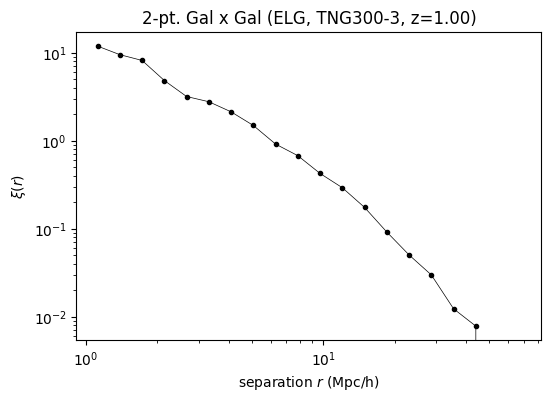

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ravg, ELG_galxgal, 'k.-', lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Gal x Gal (ELG, {sim.sim_tag})')

#### linear theory from Colossus

In [17]:
xi_lin = tools.linear_2pcf(z, ravg)

#### compare ratios

In [18]:
b_LRG = np.sqrt(LRG_galxgal/xi_lin)
b_ELG = np.sqrt(ELG_galxgal/xi_lin)

/tmp/ipykernel_1939530/1057634700.py:1: RuntimeWarning: invalid value encountered in sqrt
  b_LRG = np.sqrt(LRG_galxgal/xi_lin)
/tmp/ipykernel_1939530/1057634700.py:2: RuntimeWarning: invalid value encountered in sqrt
  b_ELG = np.sqrt(ELG_galxgal/xi_lin)


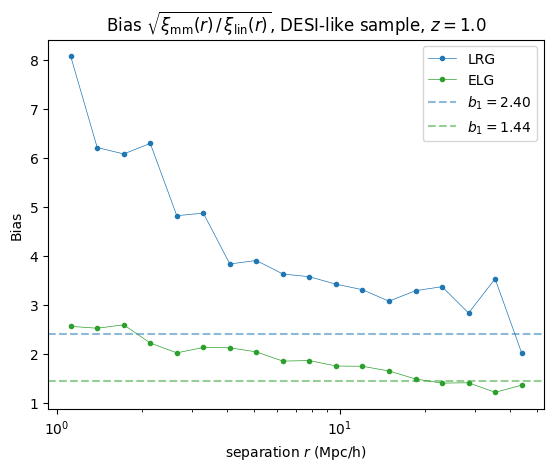

In [19]:
fig, ax = plt.subplots()

ax.plot(ravg, b_LRG, marker='.', lw=0.5, color='C0', label=r'LRG')
ax.plot(ravg, b_ELG, marker='.', lw=0.5, color='C2', label='ELG')
ax.axhline(2.4, color='C0', ls='--', alpha=0.5, label='$b_1=2.40$')
ax.axhline(1.44, color='C2', ls='--', alpha=0.5, label='$b_1=1.44$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'Bias')
ax.set_title(r'Bias $\sqrt{\xi_\mathrm{mm}(r)\,/\,\xi_\mathrm{lin}(r)}$, DESI-like sample, '+f'$z=${z}')
ax.legend()

### TNG 300-1

In [20]:
z = 1.
# initialize simulation and snapshot
sim1 = TNGSim('TNG300-1', redshift=z)

In [21]:
# luminous red galaxies / emission line galaxies -> tracers
# (input number densities from Table 1 in Sullivan et al. 2023)
LRG_idx1 = sim1.gal_idx('LRG', 'DESI', n=2e-4, prints=True)
ELG_idx1 = sim1.gal_idx('ELG', 'DESI', n=5e-4, prints=True)

input number density: 2.00e-04 (h/Mpc)^3
target number of subhalos: 1723
input number density: 5.00e-04 (h/Mpc)^3
target number of subhalos: 4307


In [22]:
LRG_idx1_n = sim1.gal_idx('LRG', 'DESI', prints=True)
ELG_idx1_n = sim1.gal_idx('ELG', 'DESI', prints=True)

LRG number density for DESI at z=1.0: 1.80e-05 (h/Mpc)^3 
target number of subhalos: 155
ELG number density for DESI at z=1.0: 5.09e-04 (h/Mpc)^3 
target number of subhalos: 4385


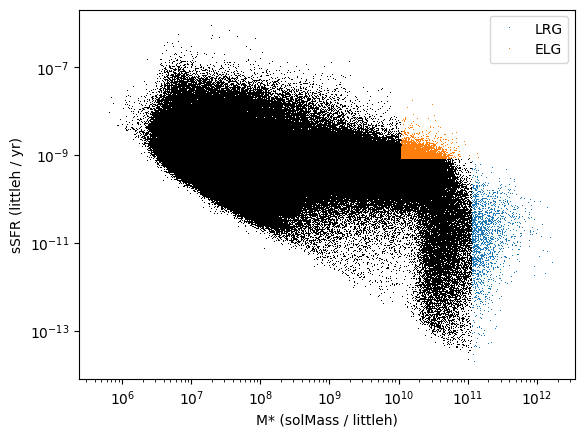

In [23]:
fig, ax = plt.subplots()
ax.plot(sim1.stellar_mass().value, sim1.sSFR().value, marker=',', ls='None', color='k')
ax.plot(sim1.stellar_mass()[LRG_idx1].value, sim1.sSFR()[LRG_idx1].value, marker=',', ls='None', label='LRG')
ax.plot(sim1.stellar_mass()[ELG_idx1].value, sim1.sSFR()[ELG_idx1].value, marker=',', ls='None', label='ELG')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'M* ({sim1.stellar_mass().unit})')
ax.set_ylabel(f'sSFR ({sim1.sSFR().unit})')
ax.legend()

In [24]:
LRG_pos1 = sim1.subhalo_pos()[LRG_idx1]
ELG_pos1 = sim1.subhalo_pos()[ELG_idx1]

In [25]:
LRG_pos1_n = sim1.subhalo_pos()[LRG_idx1_n]
ELG_pos1_n = sim1.subhalo_pos()[ELG_idx1_n]

In [26]:
ravg, LRG_galxgal1 = corrfunc_ls.compute_3D_ls_auto(LRG_pos1.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)
ravg, ELG_galxgal1 = corrfunc_ls.compute_3D_ls_auto(ELG_pos1.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)

In [27]:
ravg, LRG_galxgal1_n = corrfunc_ls.compute_3D_ls_auto(LRG_pos1_n.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)
ravg, ELG_galxgal1_n = corrfunc_ls.compute_3D_ls_auto(ELG_pos1_n.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)

/work/08811/aew492/ls6/small-scale_cross-corrs/corrfunc_ls.py:61: RuntimeWarning: Mean of empty slice
  return r_avg, np.nanmean(xis, axis=0)


In [28]:
b_LRG1 = np.sqrt(LRG_galxgal1/xi_lin)
b_ELG1 = np.sqrt(ELG_galxgal1/xi_lin)

/tmp/ipykernel_1939530/4045040962.py:1: RuntimeWarning: invalid value encountered in sqrt
  b_LRG1 = np.sqrt(LRG_galxgal1/xi_lin)
/tmp/ipykernel_1939530/4045040962.py:2: RuntimeWarning: invalid value encountered in sqrt
  b_ELG1 = np.sqrt(ELG_galxgal1/xi_lin)


In [29]:
b_LRG1_n = np.sqrt(LRG_galxgal1_n/xi_lin)
b_ELG1_n = np.sqrt(ELG_galxgal1_n/xi_lin)

/tmp/ipykernel_1939530/3351011197.py:1: RuntimeWarning: invalid value encountered in sqrt
  b_LRG1_n = np.sqrt(LRG_galxgal1_n/xi_lin)
/tmp/ipykernel_1939530/3351011197.py:2: RuntimeWarning: invalid value encountered in sqrt
  b_ELG1_n = np.sqrt(ELG_galxgal1_n/xi_lin)


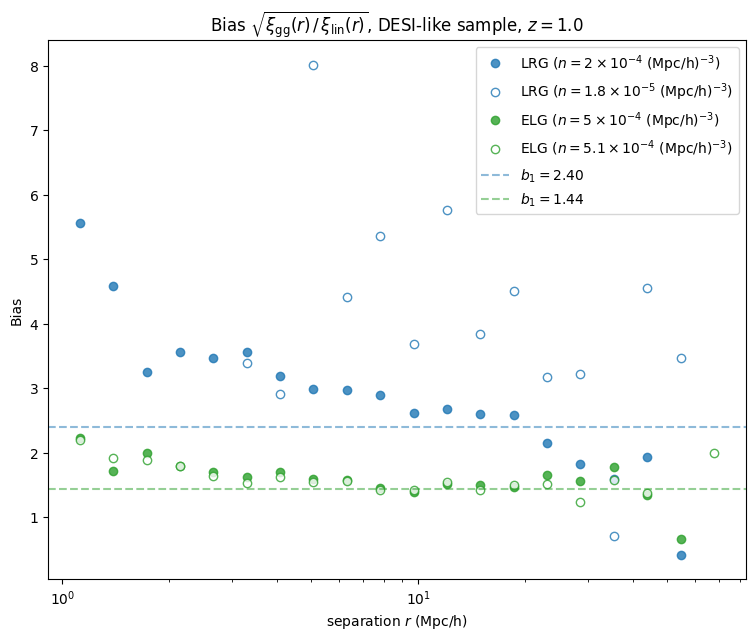

In [30]:
fig, ax = plt.subplots(figsize=(9,7))

kwargs = dict(marker='o', ls='None', alpha=0.8)

ax.plot(ravg, b_LRG1, color='C0', label=r'LRG ($n=2\times 10^{-4}$ (Mpc/h)$^{-3}$)', **kwargs)
ax.plot(ravg, b_LRG1_n, color='w', mec='C0', label=r'LRG ($n=1.8\times 10^{-5}$ (Mpc/h)$^{-3}$)', **kwargs)
ax.plot(ravg, b_ELG1, color='C2', label=r'ELG ($n=5\times 10^{-4}$ (Mpc/h)$^{-3}$)', **kwargs)
ax.plot(ravg, b_ELG1_n, color='w', mec='C2', label=r'ELG ($n=5.1\times 10^{-4}$ (Mpc/h)$^{-3}$)', **kwargs)

ax.axhline(2.4, color='C0', ls='--', alpha=0.5, label='$b_1=2.40$')
ax.axhline(1.44, color='C2', ls='--', alpha=0.5, label='$b_1=1.44$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'Bias')
ax.set_title(r'Bias $\sqrt{\xi_\mathrm{gg}(r)\,/\,\xi_\mathrm{lin}(r)}$, DESI-like sample, '+f'$z=${z}')
ax.legend()

### Gal x DM

In [31]:
# load dark matter for TNG300-3
z = 1.
sim = TNGSim('TNG300-3', redshift=z)

In [46]:
%%time
ravg, xi_elgxdm = sim.galxdm('ELG', n=5e-4, rmin=rmin, rmax=rmax, nbins=nbins, prints=True)

subsampling 2441406 random particles...
input number density: 5.00e-04 (h/Mpc)^3
target number of subhalos: 4307
D1D2 calculated
D1R calculated
D2R calculated
RR calculated
3d counts converted to cf
CPU times: user 4h 14min 37s, sys: 4.62 s, total: 4h 14min 42s
Wall time: 10min 56s


In [ ]:
%%

In [33]:
b_cross = xi_elgxdm / xi_lin

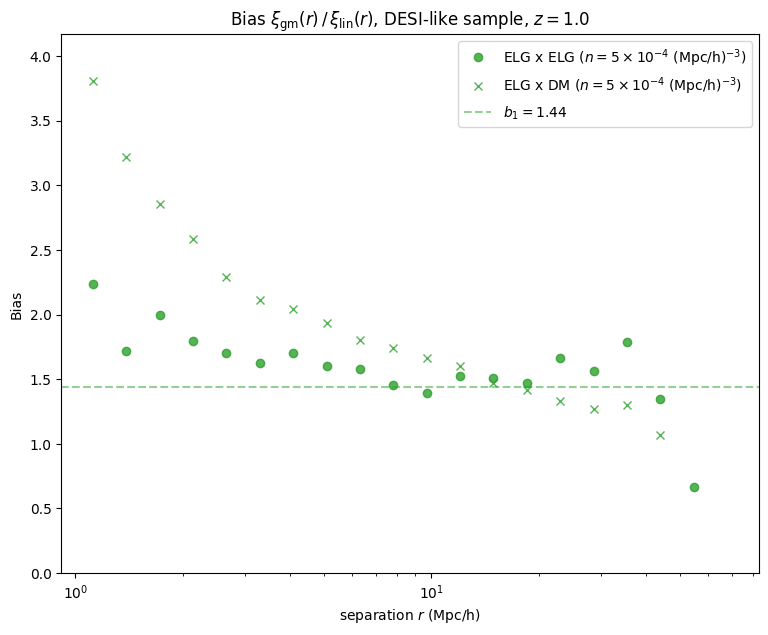

In [36]:
fig, ax = plt.subplots(figsize=(9,7))

kwargs = dict(ls='None', alpha=0.8)

ax.plot(ravg, b_ELG1, color='C2', marker='o', label=r'ELG x ELG ($n=5\times 10^{-4}$ (Mpc/h)$^{-3}$)', **kwargs)
ax.plot(ravg, b_cross, color='C2', marker='x', label=r'ELG x DM ($n=5\times 10^{-4}$ (Mpc/h)$^{-3}$)', **kwargs)

ax.axhline(1.44, color='C2', ls='--', alpha=0.5, label='$b_1=1.44$')

ax.set_ylim(0,None)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'Bias')
ax.set_title(r'Bias $\xi_\mathrm{gm}(r)\,/\,\xi_\mathrm{lin}(r)$, DESI-like sample, '+f'$z=${z}')
ax.legend()